In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools
import scipy.signal
import tsfresh
import pickle
from tqdm import tqdm
import inspect
import sys
sys.path.append("src/data_processing/")
sys.path.append("src/validation/")
import dp_utils as dp

In [ ]:
%%time

filepath = '/home/sergey/Projects/Kaggle/LANL-Earthquake-Prediction/train.csv'

df = pd.read_csv(filepath, 
                 dtype={"acoustic_data": np.int16, "time_to_failure": np.float32}, 
                 skiprows=1, 
                 names=['s', 'ttf'])

In [ ]:
filepath = '/home/sergey/Projects/Kaggle/LANL-Earthquake-Prediction/train/train.h5'

df.to_hdf(filepath, key='table')

In [ ]:
# filepath = '/home/sergey/Projects/Kaggle/LANL-Earthquake-Prediction/train/train.h5'
# filepath = '/Users/sergey/Dev/Kaggle/LANL-Earthquake-Prediction/train/train.h5'
filepath = '/Users/sergey/Dev/Kaggle/LANL-Earthquake-Prediction/train/train_short.h5'

df = pd.read_hdf(filepath, key='table')

In [10]:
# filepath = './data/train_short_processed.h5'
filepath = '/Users/sergey/Dev/Kaggle/LANL-Earthquake-Prediction/train/train_processed.h5'

df_processed = pd.read_hdf(filepath, key='table')

In [ ]:
from inspect import getmembers, isfunction

funcname_list = [o[0] for o in getmembers(dp) if isfunction(o[1])]
funcref_list = [o[1] for o in getmembers(dp) if isfunction(o[1])]

In [ ]:
import json

dp_config = {"data_path": "../../data/train_short.h5", 
             "data_processed_path": "../../data/train_short_processed.h5", 
             "window_length": 10000,
             "routines": {}}

In [ ]:
for obj in funcref_list[:-1]:
    inspect_obj = inspect.signature(obj)
    params_dict = dict(inspect_obj.parameters)
    params = {}
    for k, v in params_dict.items():
        if v.default != inspect._empty:
            params[k] = v.default      
    dp_config["routines"][obj.__name__] = {"on": True, "params": params}
    
dp_config

In [ ]:
func_list = []
for name in list(dp_config['routines'].keys()):
    func_list.append(getattr(dp, name))

# 3. Run processing
routine_settings = list(dp_config['routines'].values())

dfp = pd.concat(
    [func(df['s'], **setting['params']) for func, setting in zip(func_list, routine_settings) if setting['on']],
    axis=1)

In [5]:
with open("/Users/sergey/Documents/Projects/Kaggle/LANL-Earthquake/src/validation/Model 1", 'rb') as file:  
    pickle_model = pickle.load(file)

/anaconda3/envs/p-sci/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


4.4826051866918695


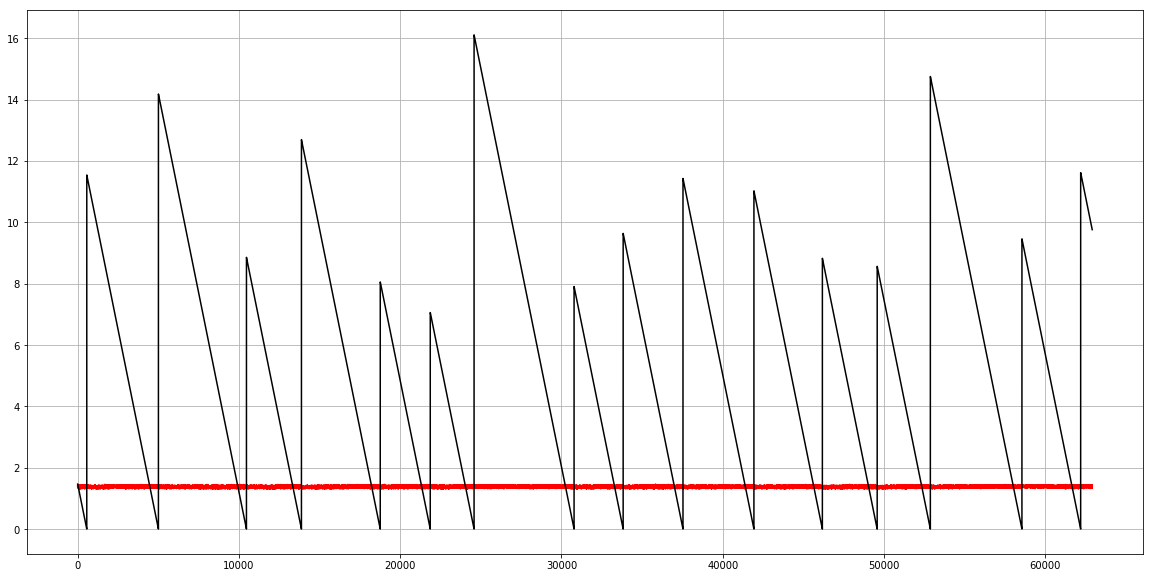

In [8]:
predictions = pickle_model.predict(df_processed.drop(['w_labels'], axis=1))
actual_values = df_processed['w_labels']
print(np.mean(abs(predictions - actual_values)))

plt.figure(figsize=(20, 10))
plt.plot(predictions, 'r')
plt.plot(actual_values, 'k')
plt.grid(True)
plt.show()

In [ ]:
from scipy.signal import savgol_filter

plt.figure(figsize=(20, 10))
plt.plot(df['s'])
plt.plot(savgol_filter(df['s'], window_length=21, polyorder=1))

In [ ]:
t = {}
if not t:
    print("H")

In [ ]:
@window_decorator()
def w_last(df, *args, **kwargs):
    return df[-1]

In [ ]:
df_processed = df_processed.join(dp.w_labels(df['ttf']))

In [ ]:
df_processed

In [ ]:
w_last(df['ttf'])

In [ ]:
def window_decorator(window_size=10000):
    def window_calc(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            temp = []
            df = args[0]
            inspect_params = inspect.getfullargspec(func)
            for i in tqdm(range(0, df.shape[0], window_size), 
                    desc=func.__name__ + "({}, ".format(*inspect_params.args)
                          + ', '.join("{}={})".format(k, v) for k, v in kwargs.items())):
                batch = df.iloc[i: i+window_size].values
                temp.append(func(batch, *args, **kwargs))
            return pd.DataFrame(temp, columns={func.__name__})
        return wrapper
    return window_calc

In [ ]:
@window_decorator()
def w_autocorrelation(df, *args, lag=100, **kwargs):
    return tsfresh.feature_extraction.feature_calculators.autocorrelation(df, lag=lag)
@window_decorator()
def w_psd(df, *args, fs=4e6, **kwargs):
    return np.sum(scipy.signal.periodogram(df, fs=fs)[1])
@window_decorator()
def w_min(df, *args, **kwargs):
    return np.min(df)
@window_decorator()
def w_absolute_sum_of_changes(df, *args, **kwargs):
    return tsfresh.feature_extraction.feature_calculators.absolute_sum_of_changes(df)
@window_decorator()
def w_sample_entropy(df, *args, **kwargs):
    return tsfresh.feature_extraction.feature_calculators.sample_entropy(df)
@window_decorator()
def w_symmetry_looking(df, *args, r=0.1, **kwargs):
    return tsfresh.feature_extraction.feature_calculators.symmetry_looking(df, param={"r": r})

In [ ]:
w_autocorrelation(df['s'], lag=10)

In [ ]:
@window_decorator()
def w_min(df, *args, **kwargs):
    return np.min(df)

@window_decorator()
def w_max(df, *args, **kwargs):
    return np.max(df)

@window_decorator()
def w_min(df, *args, **kwargs):
    return np.min(df)

In [ ]:
class DP:
    def __init__(self, df):
        self.df = df
        
    

    @window_decorator()
    def w_mean(self, *args, **kwargs):
        return np.mean(self.df)

    @window_decorator()
    def w_std(self, *args, **kwargs):
        return np.std(self.df)

#     @window_decorator()
#     def w_min(df, *args, **kwargs):
#         return np.min(df)

#     @window_decorator()
#     def w_max(df, *args, **kwargs):
#         return np.max(df)

#     @window_decorator()
#     def w_min(df, *args, **kwargs):
#         return np.min(df)

#     @window_decorator()
#     def w_abs_energy(df, *args, **kwargs):
#         return tsfresh.feature_extraction.feature_calculators.abs_energy(df)

#     @window_decorator()
#     def w_binned_entropy(df, *args, **kwargs):
#         return tsfresh.feature_extraction.feature_calculators.binned_entropy(df, kwargs['max_bins'])